In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re

# from sklearn.feature_extraction.text import CountVectorizer

import pymongo

from sklearn import preprocessing
# from sklearn.model_selection import train_test_split
from sklearn import metrics

from wordcloud import WordCloud,STOPWORDS 

# SETTING
plt.style.use('ggplot')
#display maximum column and rows
pd.options.display.max_columns = 999
pd.options.display.min_rows = 999
pd.options.display.max_colwidth = 999
stopword = STOPWORDS
stopword.add('im')
stopword.add('youre')


red = '#ef4b4b'
black = '#584b42'
green = '#a0cc78'
yellow_ = '#f6d365'
blue_ = '#49beb7'

#INIT


#METHODS
def sep():
    print(100*'-')

def connectMongoDB(dbname):
    client = pymongo.MongoClient('localhost', 27017)
    db = client[dbname]
    return db

dbname = 'clothing_fit'
db = connectMongoDB(dbname)

In [3]:
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split
import recmetrics

In [4]:
rent = list(db.rentCollection.find())
df_rent = pd.DataFrame(rent)
df_rent

# MENGECEK NULL
print("banyak data : ", len(df_rent))
print("columns : ", df_rent.columns)

df_rent.info()
df_rent.isnull().sum()

banyak data :  20027
columns :  Index(['_id', 'fit', 'user_id', 'bust size', 'item_id', 'weight', 'rating',
       'rented for', 'review_text', 'body type', 'review_summary', 'category',
       'height', 'size', 'age', 'review_date', 'sentiment_', 'height_cm',
       'weight_kg', 'age_', 'review_date_', 'sentiment_summary',
       'sentiment_text'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20027 entries, 0 to 20026
Data columns (total 23 columns):
_id                  20027 non-null object
fit                  20027 non-null object
user_id              20027 non-null object
bust size            18126 non-null object
item_id              20027 non-null object
weight               16866 non-null object
rating               20024 non-null float64
rented for           20027 non-null object
review_text          20027 non-null object
body type            18517 non-null object
review_summary       20027 non-null object
category             20027 non-null object


_id                     0
fit                     0
user_id                 0
bust size            1901
item_id                 0
weight               3161
rating                  3
rented for              0
review_text             0
body type            1510
review_summary          0
category                0
height                 76
size                    0
age                   103
review_date             0
sentiment_              0
height_cm               0
weight_kg            3161
age_                    0
review_date_            0
sentiment_summary       0
sentiment_text          0
dtype: int64

In [5]:
df_rent = df_rent.dropna(subset=['weight_kg', 'body type'])
df_rent.isnull().sum()

_id                    0
fit                    0
user_id                0
bust size            679
item_id                0
weight                 0
rating                 0
rented for             0
review_text            0
body type              0
review_summary         0
category               0
height                49
size                   0
age                   40
review_date            0
sentiment_             0
height_cm              0
weight_kg              0
age_                   0
review_date_           0
sentiment_summary      0
sentiment_text         0
dtype: int64

# Menyeleksi transaksi dengan rating di atas 6

In [7]:
print(df_rent.shape)
ratings = df_rent.query('rating >=6')
ratings.shape
# ratings.head(2)

ratings.reset_index(drop=True, inplace=True)

(15982, 24)


# Melabeli ID item dengan size nya
karena item dengan size berbeda merupakan entitas yang berbeda untuk masing-masing karakteristik pelanggan

In [8]:
df_rent['item_id_size'] = list(map(lambda a, b : tuple([a, b]),df_rent['item_id'], df_rent['size'] ))
df_rent[['item_id_size']].head()

ratings['item_id_size'] = list(map(lambda a, b : tuple([a, b]),ratings['item_id'], ratings['size'] ))
ratings[['item_id_size']].head()

c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,item_id_size
0,"(2260466, 14)"
1,"(153475, 12)"
2,"(126335, 8)"
3,"(616682, 12)"
4,"(364092, 8)"


ada 15982 transaksi dengan rating lebih dari 6

In [9]:
ratings.head()


#only consider ratings from users who have rated over 2 clothes
users = ratings.user_id.value_counts()
type(users)
n = users.quantile(0.9)
print(n)
users = users[users>n].index.tolist()
users # user_id yang telah vote lebihdari 3 kali.

len(users) # ada 358 users yang termasuk dalam requirement

2.0


358

persentil ke 90 dari frekuensi user menyewa adalah 2.

ada 358 user yang sudah menyewa lebih dari 2 kali

In [10]:
ratings = ratings.query('user_id in @users')
print(ratings.shape) # ada 1454 transaksi yang dilakukan oleh 358 users
# ratings.head(1)


(1454, 24)


dari 358 users, ada 1454 transaksi yang dilakukan oleh user tersebut di dalam data

<hr>

# Get Item Feature

#### mencari list item yang ada dalam transaksi df ratings

In [11]:
rated_items = ratings.groupby(['item_id','size']).count().index.tolist()
print(rated_items[:3])

[('1000254', 16), ('1009546', 20), ('1009845', 28)]


In [12]:
# enumerate id dari rated_items, untuk membentuk matriks ITEMS

items = df_rent.query('item_id_size in @rated_items')
items.set_index("item_id_size", inplace=True, drop=True)
items.head(1)
items.shape

(2654, 23)



## kategori

In [13]:
# get items feature

items.columns

items = items.category.str.split("|", expand=True)
items
items.reset_index(inplace=True)
items
items = pd.melt(items, id_vars='item_id_size', value_vars=[0])             #variabel 0-> untuk kategori
items.head()


,item_id_size,variable,value
0,"(616682, 12)",0,gown
1,"(568429, 4)",0,dress
2,"(1729232, 1)",0,gown
3,"(172027, 8)",0,dress
4,"(197391, 12)",0,dress


In [14]:
items.drop_duplicates("item_id_size", inplace=True)
items.set_index('item_id_size', inplace=True)
items

print(items.shape)
items = pd.get_dummies(items.value)
items.head()


(1390, 2)


,blazer,blouse,bomber,caftan,cape,cardigan,coat,combo,culotte,culottes,down,dress,gown,henley,hoodie,jacket,jogger,jumpsuit,knit,maxi,midi,mini,pant,pants,poncho,print,pullover,romper,sheath,shift,shirt,shirtdress,skirt,sweater,sweatshirt,tank,top,trench,trouser,tunic,turtleneck,vest
item_id_size,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(616682, 12)",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"(568429, 4)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"(1729232, 1)",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"(172027, 8)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"(197391, 12)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## mean rating

In [15]:
mean_rating = ratings.groupby(['item_id','size']).mean()[['rating']]
mean_rating['vote_count'] = ratings.groupby(['item_id','size']).count()[['_id']]

mean_rating.reset_index(inplace=True)
mean_rating = mean_rating[['rating', 'vote_count']]
mean_rating
mean_rating.shape
# mean_rating


#membuat df mean_rating memiliki index yg sama dengan items
mean_rating['item_id_size'] = items.index
mean_rating.set_index('item_id_size', inplace=True)
mean_rating.shape


(1390, 2)

In [16]:
# Calculate C (mean vote dari semua data yang tersedia)

C = mean_rating['rating'].mean()
print(C)

# Calculate the minimum number of votes required to be in the chart, m 
## persentil ke 90 dari angka vote keseluruhan data
m = mean_rating['vote_count'].quantile(0.90)
print(m)

mean_rating = mean_rating.copy().loc[mean_rating['vote_count'] >= m]
print("setelah filter : ", mean_rating.shape)

# Function that computes the weighted rating of each clothes

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['rating']
    
    # Calculation based on the IMDB formula
    # jumlah Nvote * rating
    return (v/(v+m) * R) + (m/(m+v) * C)

9.110791366906474
1.0
setelah filter :  (1390, 2)


In [17]:
mean_rating['weighted_rating'] = mean_rating.apply(weighted_rating, axis=1)
mean_rating.head()
mean_rating.shape

(1390, 3)

In [18]:
items['rating'] = mean_rating['rating']
items['score'] = mean_rating['weighted_rating']
print(items.shape)
items.head()
# items.isnull().sum()

(1390, 44)


,blazer,blouse,bomber,caftan,cape,cardigan,coat,combo,culotte,culottes,down,dress,gown,henley,hoodie,jacket,jogger,jumpsuit,knit,maxi,midi,mini,pant,pants,poncho,print,pullover,romper,sheath,shift,shirt,shirtdress,skirt,sweater,sweatshirt,tank,top,trench,trouser,tunic,turtleneck,vest,rating,score
item_id_size,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(616682, 12)",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,9.555396
"(568429, 4)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,9.555396
"(1729232, 1)",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,9.555396
"(172027, 8)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,9.555396
"(197391, 12)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,7.555396


#### Ada sebanyak 1390 item unique dengan 44 feature (hasil dari kategori + rating + weighted_rating)

In [19]:
print(ratings.shape) # smua transaksi user
print(items.shape)   # items yg terlibat transaksi (metadata info)

(1454, 24)
(1390, 44)


# Long Tail Plot

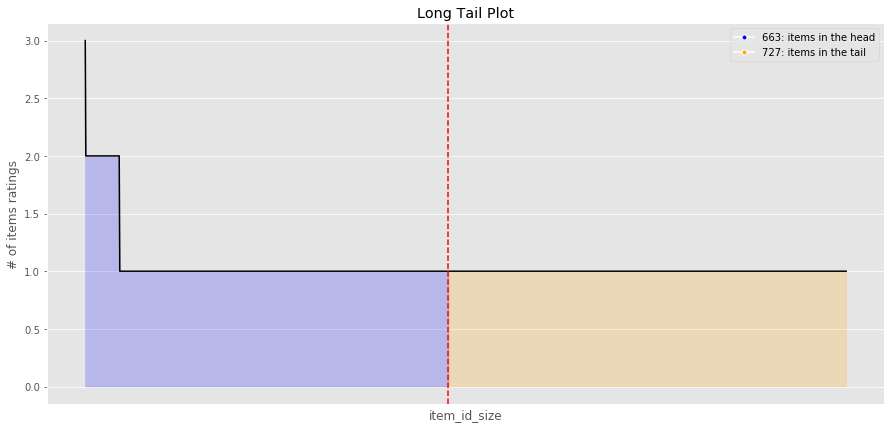

In [20]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="item_id_size", 
             interaction_type="items ratings", 
             percentage=0.5,
             x_labels=False)

- 663 items populer
- 727 tidak populer

The metrics identified here provide methods for evaluating both the relevancy and usefulness of recommendations.

# Collaborative Filtering

In [262]:
ratings[['user_id', 'item_id_size', 'rating']]
user_valid = ratings['user_id'].value_counts()
user_valid = list(user_valid.index)
user_valid

['691468',
 '32925',
 '45337',
 '833675',
 '742630',
 '375703',
 '472391',
 '491589',
 '388317',
 '570030',
 '764926',
 '215971',
 '257847',
 '96369',
 '667260',
 '630850',
 '113975',
 '733207',
 '958548',
 '269712',
 '441632',
 '995826',
 '546282',
 '597442',
 '761246',
 '260350',
 '676222',
 '406567',
 '818141',
 '134802',
 '46566',
 '975196',
 '879713',
 '127505',
 '362031',
 '336066',
 '273636',
 '748397',
 '495160',
 '78488',
 '907296',
 '252311',
 '425551',
 '768426',
 '281976',
 '418925',
 '359031',
 '667471',
 '266243',
 '402094',
 '994398',
 '232353',
 '162244',
 '984042',
 '691606',
 '425606',
 '221407',
 '88342',
 '927813',
 '45387',
 '762464',
 '377223',
 '551640',
 '47002',
 '70714',
 '659410',
 '725872',
 '27229',
 '116211',
 '855337',
 '215267',
 '97207',
 '602595',
 '427632',
 '933801',
 '250765',
 '859301',
 '380920',
 '720118',
 '647498',
 '34188',
 '273767',
 '444586',
 '580936',
 '252421',
 '92826',
 '349774',
 '132361',
 '227475',
 '495314',
 '726839',
 '594923',
 

In [176]:
ratings[['user_id', 'item_id_size', 'rating']]
ratings.user_id.nunique()
ratings.item_id_size.nunique()
ratings.rating.value_counts()

10.0    913
8.0     436
6.0     105
Name: rating, dtype: int64

In [153]:
#format data for surprise
reader = Reader(rating_scale=(2, 10))

data = Dataset.load_from_df(ratings[['user_id', 'item_id_size', 'rating']], reader)  # id user, id item, rating yang diberikan transaksi


In [189]:

trainset, testset = train_test_split(data, test_size=0.25)

## SVD

In [190]:
#train SVD recommender 
algo = SVD()
algo.fit(trainset)


In [191]:
from surprise.model_selection import cross_validate
# Run 5-fold cross-validation and print results

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1482  1.3024  1.1258  1.2719  1.2270  1.2151  0.0685  
MAE (testset)     1.0076  1.1008  1.0197  1.0954  1.0709  1.0589  0.0385  
Fit time          0.18    0.21    0.18    0.23    0.21    0.20    0.02    
Test time         0.01    0.00    0.00    0.00    0.00    0.01    0.00    


{'test_rmse': array([1.14822509, 1.30238238, 1.12578671, 1.27190508, 1.22701699]),
 'test_mae': array([1.00758548, 1.10082353, 1.01967685, 1.0953857 , 1.07086311]),
 'fit_time': (0.18191266059875488,
  0.2088778018951416,
  0.18489289283752441,
  0.23386359214782715,
  0.20988202095031738),
 'test_time': (0.009978055953979492,
  0.003998279571533203,
  0.0039997100830078125,
  0.004996061325073242,
  0.0029993057250976562)}

## KNN Basic

In [192]:
from surprise import KNNBasic

#train SVD recommender 
algo2 = KNNBasic()
algo2.fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [193]:
# Run 5-fold cross-validation and print results

cross_validate(algo2, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2393  1.3211  1.1734  1.2657  1.2552  1.2509  0.0475  
MAE (testset)     1.1069  1.1556  1.0728  1.1241  1.1183  1.1156  0.0268  
Fit time          0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.23927849, 1.32106535, 1.17341476, 1.26570589, 1.2552003 ]),
 'test_mae': array([1.10692515, 1.15559653, 1.07283273, 1.12412206, 1.11828416]),
 'fit_time': (0.010993242263793945,
  0.007993221282958984,
  0.0069925785064697266,
  0.0099945068359375,
  0.011992216110229492),
 'test_time': (0.011994600296020508,
  0.007995367050170898,
  0.007996082305908203,
  0.009994029998779297,
  0.014994621276855469)}

# SVDpp

In [194]:
from surprise.prediction_algorithms.matrix_factorization import SVDpp

#train SVD recommender 
algo3 = SVDpp()
algo3.fit(trainset)


In [195]:
# Run 5-fold cross-validation and print results

cross_validate(algo3, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2314  1.2466  1.1814  1.2493  1.1726  1.2163  0.0328  
MAE (testset)     1.0523  1.0636  1.0253  1.0598  1.0259  1.0454  0.0166  
Fit time          0.66    0.52    0.47    0.65    0.54    0.57    0.07    
Test time         0.01    0.00    0.00    0.00    0.00    0.01    0.00    


{'test_rmse': array([1.2314433 , 1.24659106, 1.18143506, 1.24929697, 1.17256681]),
 'test_mae': array([1.05230652, 1.06362218, 1.02528581, 1.05983475, 1.02586747]),
 'fit_time': (0.6556215286254883,
  0.5246982574462891,
  0.4697303771972656,
  0.6546251773834229,
  0.5426697731018066),
 'test_time': (0.013994216918945312,
  0.0049974918365478516,
  0.004998445510864258,
  0.003997325897216797,
  0.0049974918365478516)}

In [196]:
#make predictions on test set. 

test = algo.test(testset)
test2 = algo2.test(testset)
test3 = algo3.test(testset)

In [197]:
from surprise import accuracy

# Then compute accuracy
print("---- error rate ----- ")

print("SVD")
accuracy.mse(test)
accuracy.rmse(test)
accuracy.mae(test)
# accuracy.fcp(test)

sep()
print("KNN Basic")
accuracy.mse(test2)
accuracy.rmse(test2)
accuracy.mae(test2)
# accuracy.fcp(test2)

sep()

print("SVD pp")
accuracy.mse(test3)
accuracy.rmse(test3)
accuracy.mae(test3)
# accuracy.fcp(test3)

---- error rate ----- 
SVD
MSE: 0.8032
RMSE: 0.8962
MAE:  0.7681
----------------------------------------------------------------------------------------------------
KNN Basic
MSE: 0.3142
RMSE: 0.5605
MAE:  0.2514
----------------------------------------------------------------------------------------------------
SVD pp
MSE: 0.8347
RMSE: 0.9136
MAE:  0.7739


0.7739364170389629

In [198]:
testAll = pd.DataFrame(test)
testAll
testAll.drop("details", inplace=True, axis=1) # column mula2 -> uid, iid, r_ui, est
testAll
testAll.columns = ['user_id', 'item_id_size', 'actual', 'cf_predictions']
testAll.head()

,user_id,item_id_size,actual,cf_predictions
0,725872,"(1014880, 20)",6.0,8.127900
1,112850,"(545632, 8)",10.0,9.016563
2,113975,"(379441, 8)",10.0,9.736363
3,518720,"(1549943, 45)",8.0,8.749401
4,269712,"(1522253, 8)",10.0,9.023505


In [199]:
test2 = pd.DataFrame(test2)
test2.head()
testAll['knn_basic_pred'] =test2['est']

test3 = pd.DataFrame(test3)
test3.head()
testAll['svd_pp_pred'] =test3['est']
testAll

,user_id,item_id_size,actual,cf_predictions,knn_basic_pred,svd_pp_pred
0,725872,"(1014880, 20)",6.0,8.127900,6.000000,7.919894
1,112850,"(545632, 8)",10.0,9.016563,9.120275,9.394687
2,113975,"(379441, 8)",10.0,9.736363,10.000000,9.690857
3,518720,"(1549943, 45)",8.0,8.749401,9.120275,8.921145
4,269712,"(1522253, 8)",10.0,9.023505,10.000000,9.518852
5,423728,"(2089809, 8)",10.0,9.442491,10.000000,9.323618
6,748397,"(1320203, 8)",8.0,8.854537,8.000000,9.183650
7,273636,"(412212, 14)",10.0,9.603218,10.000000,9.498158
8,201974,"(553936, 4)",10.0,9.490570,10.000000,9.313492
9,213016,"(133584, 12)",10.0,8.924718,9.120275,9.265738


In [200]:
#evaluate model with MSE and RMSE via recmetrics

print(recmetrics.mse(testAll.actual, testAll.cf_predictions))
print(recmetrics.rmse(testAll.actual, testAll.cf_predictions))
sep()
print(recmetrics.mse(testAll.actual, testAll.knn_basic_pred))
print(recmetrics.rmse(testAll.actual, testAll.knn_basic_pred))
sep()
print(recmetrics.mse(testAll.actual, testAll.svd_pp_pred))
print(recmetrics.rmse(testAll.actual, testAll.svd_pp_pred))

0.8032138662582418
0.8962219960803471
----------------------------------------------------------------------------------------------------
0.31417742668495496
0.5605153224354843
----------------------------------------------------------------------------------------------------
0.8346521369283144
0.913592982092307


In [201]:
#create model (matrix of predicted values)

cf_model = testAll.pivot_table(index='user_id', columns='item_id_size', values='cf_predictions').fillna(0)
print(cf_model.shape)
cf_model.head()

(240, 359)


item_id_size,"(1000254, 16)","(1009845, 28)","(1014880, 20)","(1017726, 35)","(1017773, 20)","(1034310, 20)","(1034372, 8)","(1051003, 4)","(1053467, 12)","(1063761, 8)","(1073611, 1)","(1076484, 16)","(1098399, 16)","(1099530, 4)","(1110676, 20)","(1113191, 4)","(1121132, 4)","(1133906, 4)","(1138140, 4)","(1142056, 20)","(1154504, 12)","(1154732, 24)","(1158451, 1)","(1158451, 4)","(1213752, 8)","(1223581, 4)","(1223725, 16)","(123373, 16)","(124553, 8)","(1250402, 4)","(1255726, 4)","(1257812, 20)","(1260731, 4)","(1260731, 14)","(127865, 13)","(128730, 16)","(1289744, 12)","(1299190, 1)","(1299555, 8)","(1310167, 8)","(1314014, 4)","(1314666, 8)","(1316404, 12)","(1316534, 1)","(1320203, 8)","(1329015, 12)","(1329021, 4)","(1333481, 4)","(1334351, 8)","(133584, 12)","(1344940, 12)","(1346753, 16)","(1346753, 28)","(1355618, 8)","(136110, 4)","(136860, 1)","(1375928, 14)","(1378631, 1)","(1383415, 8)","(1383632, 16)","(1384766, 1)","(1386350, 4)","(1392841, 12)","(141300, 4)","(1414750, 20)","(143094, 4)","(145906, 7)","(1459683, 16)","(1469072, 12)","(148690, 16)","(1499752, 20)","(1505709, 20)","(1514308, 20)","(1516843, 1)","(1522253, 8)","(1522253, 14)","(1523096, 16)","(1523882, 4)","(152836, 12)","(1542250, 39)","(1542251, 8)","(1549943, 45)","(1570915, 8)","(1576857, 4)","(1576942, 8)","(1578308, 1)","(1589928, 4)","(1593041, 24)","(1600987, 8)","(1615177, 12)","(1621646, 20)","(1629567, 16)","(1639988, 12)","(1648416, 4)","(1649107, 8)","(1651169, 4)","(1652667, 1)","(166006, 16)","(166633, 8)","(1671818, 16)","(1679360, 8)","(1685669, 14)","(1719559, 4)","(172914, 8)","(1734300, 8)","(1739627, 4)","(174086, 1)","(1745932, 24)","(174799, 16)","(174799, 20)","(1749759, 1)","(1752487, 8)","(1769671, 16)","(1776178, 8)","(178058, 4)","(1780941, 12)","(1783600, 20)","(1787191, 12)","(1788074, 20)","(1795593, 20)","(1799162, 4)","(1799162, 16)","(1813420, 8)","(1813420, 12)","(1814462, 8)","(1819243, 8)","(1821048, 16)","(1822664, 8)","(1842684, 8)","(1845435, 17)","(1853367, 8)","(1855564, 14)","(1858651, 8)","(1859039, 14)","(1859977, 4)","(1861964, 16)","(1861964, 24)","(1869763, 12)","(1875650, 4)","(1877861, 8)","(1894639, 20)","(1895348, 1)","(1895348, 16)","(1905844, 12)","(1909065, 13)","(1913039, 1)","(1924247, 4)","(1940255, 24)","(194182, 8)","(1944337, 4)","(1951168, 8)","(1954824, 4)","(197391, 12)","(1976130, 8)","(1984705, 1)","(1992563, 4)","(1994978, 8)","(1995373, 8)","(2002292, 4)","(2011987, 1)","(2014707, 14)","(2015822, 8)","(2033686, 5)","(2035790, 8)","(2046224, 24)","(2053531, 8)","(2057975, 4)","(2057975, 8)","(2059409, 8)","(2060880, 4)","(2063849, 8)","(2071488, 8)","(2073553, 8)","(2077141, 8)","(208647, 8)","(2089809, 8)","(2098918, 8)","(2117415, 8)","(2120468, 1)","(2121378, 12)","(2130194, 8)","(2135899, 14)","(2140050, 8)","(2148471, 4)","(2158754, 8)","(2164765, 4)","(2196467, 14)","(2209432, 4)","(2226744, 4)","(2231774, 20)","(2252462, 4)","(2252462, 14)","(2257456, 16)","(2259753, 8)","(226072, 12)","(2292972, 4)","(2300010, 8)","(2303128, 8)","(2319586, 8)","(2343090, 1)","(2363191, 1)","(2367913, 14)","(2376757, 20)","(2378271, 14)","(241759, 12)","(2440235, 4)","(2443419, 8)","(2444721, 12)","(2465306, 8)","(2472076, 12)","(247465, 1)","(2483440, 8)","(2484216, 14)","(2494898, 8)","(2531493, 3)","(2537366, 14)","(2541835, 16)","(2546173, 16)","(2552714, 8)","(2553295, 8)","(2557055, 12)","(2573155, 4)","(2575124, 12)","(2578061, 4)","(2599464, 4)","(2609834, 8)","(2616422, 8)","(2622144, 20)","(2635020, 14)","(2647046, 4)","(2654048, 1)","(2655365, 8)","(265806, 12)","(2670837, 12)","(2686855, 16)","(2696263, 8)","(2701429, 4)","(2702384, 16)","(2707029, 8)","(2707303, 8)","(2716360, 12)","(2729447, 4)","(2730831, 4)","(2752000, 16)","(2758095, 4)","(276763, 8)","(2769576, 2)","(2775831, 12)","(2780710, 8)","(2785640, 20)","(2787036, 8)","(2787036, 14)","(2791864, 12)","(279859, 1)","(2806136, 8)","(2827807, 16)","(2828426, 4)","(2856326, 4)","(2856326, 8)","(2861781, 12)","(28624

In [202]:
#create model (matrix of predicted values)

knn_model = testAll.pivot_table(index='user_id', columns='item_id_size', values='knn_basic_pred').fillna(0)
print(knn_model.shape)
# knn_model.head()

(240, 359)


In [203]:
#create model (matrix of predicted values)

svd_pp_model = testAll.pivot_table(index='user_id', columns='item_id_size', values='svd_pp_pred').fillna(0)
print(svd_pp_model.shape)
svd_pp_model.head()

(240, 359)


item_id_size,"(1000254, 16)","(1009845, 28)","(1014880, 20)","(1017726, 35)","(1017773, 20)","(1034310, 20)","(1034372, 8)","(1051003, 4)","(1053467, 12)","(1063761, 8)","(1073611, 1)","(1076484, 16)","(1098399, 16)","(1099530, 4)","(1110676, 20)","(1113191, 4)","(1121132, 4)","(1133906, 4)","(1138140, 4)","(1142056, 20)","(1154504, 12)","(1154732, 24)","(1158451, 1)","(1158451, 4)","(1213752, 8)","(1223581, 4)","(1223725, 16)","(123373, 16)","(124553, 8)","(1250402, 4)","(1255726, 4)","(1257812, 20)","(1260731, 4)","(1260731, 14)","(127865, 13)","(128730, 16)","(1289744, 12)","(1299190, 1)","(1299555, 8)","(1310167, 8)","(1314014, 4)","(1314666, 8)","(1316404, 12)","(1316534, 1)","(1320203, 8)","(1329015, 12)","(1329021, 4)","(1333481, 4)","(1334351, 8)","(133584, 12)","(1344940, 12)","(1346753, 16)","(1346753, 28)","(1355618, 8)","(136110, 4)","(136860, 1)","(1375928, 14)","(1378631, 1)","(1383415, 8)","(1383632, 16)","(1384766, 1)","(1386350, 4)","(1392841, 12)","(141300, 4)","(1414750, 20)","(143094, 4)","(145906, 7)","(1459683, 16)","(1469072, 12)","(148690, 16)","(1499752, 20)","(1505709, 20)","(1514308, 20)","(1516843, 1)","(1522253, 8)","(1522253, 14)","(1523096, 16)","(1523882, 4)","(152836, 12)","(1542250, 39)","(1542251, 8)","(1549943, 45)","(1570915, 8)","(1576857, 4)","(1576942, 8)","(1578308, 1)","(1589928, 4)","(1593041, 24)","(1600987, 8)","(1615177, 12)","(1621646, 20)","(1629567, 16)","(1639988, 12)","(1648416, 4)","(1649107, 8)","(1651169, 4)","(1652667, 1)","(166006, 16)","(166633, 8)","(1671818, 16)","(1679360, 8)","(1685669, 14)","(1719559, 4)","(172914, 8)","(1734300, 8)","(1739627, 4)","(174086, 1)","(1745932, 24)","(174799, 16)","(174799, 20)","(1749759, 1)","(1752487, 8)","(1769671, 16)","(1776178, 8)","(178058, 4)","(1780941, 12)","(1783600, 20)","(1787191, 12)","(1788074, 20)","(1795593, 20)","(1799162, 4)","(1799162, 16)","(1813420, 8)","(1813420, 12)","(1814462, 8)","(1819243, 8)","(1821048, 16)","(1822664, 8)","(1842684, 8)","(1845435, 17)","(1853367, 8)","(1855564, 14)","(1858651, 8)","(1859039, 14)","(1859977, 4)","(1861964, 16)","(1861964, 24)","(1869763, 12)","(1875650, 4)","(1877861, 8)","(1894639, 20)","(1895348, 1)","(1895348, 16)","(1905844, 12)","(1909065, 13)","(1913039, 1)","(1924247, 4)","(1940255, 24)","(194182, 8)","(1944337, 4)","(1951168, 8)","(1954824, 4)","(197391, 12)","(1976130, 8)","(1984705, 1)","(1992563, 4)","(1994978, 8)","(1995373, 8)","(2002292, 4)","(2011987, 1)","(2014707, 14)","(2015822, 8)","(2033686, 5)","(2035790, 8)","(2046224, 24)","(2053531, 8)","(2057975, 4)","(2057975, 8)","(2059409, 8)","(2060880, 4)","(2063849, 8)","(2071488, 8)","(2073553, 8)","(2077141, 8)","(208647, 8)","(2089809, 8)","(2098918, 8)","(2117415, 8)","(2120468, 1)","(2121378, 12)","(2130194, 8)","(2135899, 14)","(2140050, 8)","(2148471, 4)","(2158754, 8)","(2164765, 4)","(2196467, 14)","(2209432, 4)","(2226744, 4)","(2231774, 20)","(2252462, 4)","(2252462, 14)","(2257456, 16)","(2259753, 8)","(226072, 12)","(2292972, 4)","(2300010, 8)","(2303128, 8)","(2319586, 8)","(2343090, 1)","(2363191, 1)","(2367913, 14)","(2376757, 20)","(2378271, 14)","(241759, 12)","(2440235, 4)","(2443419, 8)","(2444721, 12)","(2465306, 8)","(2472076, 12)","(247465, 1)","(2483440, 8)","(2484216, 14)","(2494898, 8)","(2531493, 3)","(2537366, 14)","(2541835, 16)","(2546173, 16)","(2552714, 8)","(2553295, 8)","(2557055, 12)","(2573155, 4)","(2575124, 12)","(2578061, 4)","(2599464, 4)","(2609834, 8)","(2616422, 8)","(2622144, 20)","(2635020, 14)","(2647046, 4)","(2654048, 1)","(2655365, 8)","(265806, 12)","(2670837, 12)","(2686855, 16)","(2696263, 8)","(2701429, 4)","(2702384, 16)","(2707029, 8)","(2707303, 8)","(2716360, 12)","(2729447, 4)","(2730831, 4)","(2752000, 16)","(2758095, 4)","(276763, 8)","(2769576, 2)","(2775831, 12)","(2780710, 8)","(2785640, 20)","(2787036, 8)","(2787036, 14)","(2791864, 12)","(279859, 1)","(2806136, 8)","(2827807, 16)","(2828426, 4)","(2856326, 4)","(2856326, 8)","(2861781, 12)","(28624

### steps to make predicted ratings

In [204]:
uid = '11841'
n_rec = 3
recommended_items = pd.DataFrame(cf_model.loc[uid])                # seleksi cf_model dengan userid = uid
recommended_items.columns = ["predicted_rating"]                   # rename columns yg sudah diberi predicted rating
recommended_items = recommended_items[recommended_items["predicted_rating"]!=0]
recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)  # mengurutkan dari rating yang akan diberikan user tertinggi
recommended_items = recommended_items.head(n_rec)
recommended_items.index.tolist()
# recommended_items.head()
# recommended_items.shape


[('577057', 8)]

In [281]:
cf_model.head()

item_id_size,"(1000254, 16)","(1009845, 28)","(1014880, 20)","(1017726, 35)","(1017773, 20)","(1034310, 20)","(1034372, 8)","(1051003, 4)","(1053467, 12)","(1063761, 8)","(1073611, 1)","(1076484, 16)","(1098399, 16)","(1099530, 4)","(1110676, 20)","(1113191, 4)","(1121132, 4)","(1133906, 4)","(1138140, 4)","(1142056, 20)","(1154504, 12)","(1154732, 24)","(1158451, 1)","(1158451, 4)","(1213752, 8)","(1223581, 4)","(1223725, 16)","(123373, 16)","(124553, 8)","(1250402, 4)","(1255726, 4)","(1257812, 20)","(1260731, 4)","(1260731, 14)","(127865, 13)","(128730, 16)","(1289744, 12)","(1299190, 1)","(1299555, 8)","(1310167, 8)","(1314014, 4)","(1314666, 8)","(1316404, 12)","(1316534, 1)","(1320203, 8)","(1329015, 12)","(1329021, 4)","(1333481, 4)","(1334351, 8)","(133584, 12)","(1344940, 12)","(1346753, 16)","(1346753, 28)","(1355618, 8)","(136110, 4)","(136860, 1)","(1375928, 14)","(1378631, 1)","(1383415, 8)","(1383632, 16)","(1384766, 1)","(1386350, 4)","(1392841, 12)","(141300, 4)","(1414750, 20)","(143094, 4)","(145906, 7)","(1459683, 16)","(1469072, 12)","(148690, 16)","(1499752, 20)","(1505709, 20)","(1514308, 20)","(1516843, 1)","(1522253, 8)","(1522253, 14)","(1523096, 16)","(1523882, 4)","(152836, 12)","(1542250, 39)","(1542251, 8)","(1549943, 45)","(1570915, 8)","(1576857, 4)","(1576942, 8)","(1578308, 1)","(1589928, 4)","(1593041, 24)","(1600987, 8)","(1615177, 12)","(1621646, 20)","(1629567, 16)","(1639988, 12)","(1648416, 4)","(1649107, 8)","(1651169, 4)","(1652667, 1)","(166006, 16)","(166633, 8)","(1671818, 16)","(1679360, 8)","(1685669, 14)","(1719559, 4)","(172914, 8)","(1734300, 8)","(1739627, 4)","(174086, 1)","(1745932, 24)","(174799, 16)","(174799, 20)","(1749759, 1)","(1752487, 8)","(1769671, 16)","(1776178, 8)","(178058, 4)","(1780941, 12)","(1783600, 20)","(1787191, 12)","(1788074, 20)","(1795593, 20)","(1799162, 4)","(1799162, 16)","(1813420, 8)","(1813420, 12)","(1814462, 8)","(1819243, 8)","(1821048, 16)","(1822664, 8)","(1842684, 8)","(1845435, 17)","(1853367, 8)","(1855564, 14)","(1858651, 8)","(1859039, 14)","(1859977, 4)","(1861964, 16)","(1861964, 24)","(1869763, 12)","(1875650, 4)","(1877861, 8)","(1894639, 20)","(1895348, 1)","(1895348, 16)","(1905844, 12)","(1909065, 13)","(1913039, 1)","(1924247, 4)","(1940255, 24)","(194182, 8)","(1944337, 4)","(1951168, 8)","(1954824, 4)","(197391, 12)","(1976130, 8)","(1984705, 1)","(1992563, 4)","(1994978, 8)","(1995373, 8)","(2002292, 4)","(2011987, 1)","(2014707, 14)","(2015822, 8)","(2033686, 5)","(2035790, 8)","(2046224, 24)","(2053531, 8)","(2057975, 4)","(2057975, 8)","(2059409, 8)","(2060880, 4)","(2063849, 8)","(2071488, 8)","(2073553, 8)","(2077141, 8)","(208647, 8)","(2089809, 8)","(2098918, 8)","(2117415, 8)","(2120468, 1)","(2121378, 12)","(2130194, 8)","(2135899, 14)","(2140050, 8)","(2148471, 4)","(2158754, 8)","(2164765, 4)","(2196467, 14)","(2209432, 4)","(2226744, 4)","(2231774, 20)","(2252462, 4)","(2252462, 14)","(2257456, 16)","(2259753, 8)","(226072, 12)","(2292972, 4)","(2300010, 8)","(2303128, 8)","(2319586, 8)","(2343090, 1)","(2363191, 1)","(2367913, 14)","(2376757, 20)","(2378271, 14)","(241759, 12)","(2440235, 4)","(2443419, 8)","(2444721, 12)","(2465306, 8)","(2472076, 12)","(247465, 1)","(2483440, 8)","(2484216, 14)","(2494898, 8)","(2531493, 3)","(2537366, 14)","(2541835, 16)","(2546173, 16)","(2552714, 8)","(2553295, 8)","(2557055, 12)","(2573155, 4)","(2575124, 12)","(2578061, 4)","(2599464, 4)","(2609834, 8)","(2616422, 8)","(2622144, 20)","(2635020, 14)","(2647046, 4)","(2654048, 1)","(2655365, 8)","(265806, 12)","(2670837, 12)","(2686855, 16)","(2696263, 8)","(2701429, 4)","(2702384, 16)","(2707029, 8)","(2707303, 8)","(2716360, 12)","(2729447, 4)","(2730831, 4)","(2752000, 16)","(2758095, 4)","(276763, 8)","(2769576, 2)","(2775831, 12)","(2780710, 8)","(2785640, 20)","(2787036, 8)","(2787036, 14)","(2791864, 12)","(279859, 1)","(2806136, 8)","(2827807, 16)","(2828426, 4)","(2856326, 4)","(2856326, 8)","(2861781, 12)","(28624

In [205]:
# make function for user predictions

def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[str(user_id)]) 
    recommended_items.columns = ["predicted_rating"]
#     recommended_items = recommended_items[recommended_items["predicted_rating"]!=0]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [237]:
ratings.user_id.value_counts()

691468    46
32925     29
45337     22
833675    14
742630    12
375703    11
472391    11
491589    10
388317     9
570030     9
764926     9
215971     8
257847     8
96369      8
667260     8
630850     8
113975     8
733207     7
958548     7
269712     7
441632     7
995826     6
546282     6
597442     6
761246     6
260350     6
676222     6
406567     6
818141     6
134802     6
          ..
479989     3
376450     3
221624     3
822433     3
557302     3
275108     3
278045     3
654930     3
220626     3
291190     3
41159      3
616181     3
425980     3
72033      3
762658     3
326425     3
112850     3
503301     3
154309     3
63956      3
989935     3
76612      3
294195     3
441830     3
410195     3
381092     3
635537     3
942693     3
372170     3
527269     3
Name: user_id, Length: 358, dtype: int64

In [263]:
#get example prediction

# print(get_users_predictions(375120, 10, cf_model))
# print(get_users_predictions(375120, 10, knn_model))
# print(get_users_predictions(375120, 10, svd_pp_model))

for i in user_valid:
    print(get_users_predictions(i, 5, cf_model))
    print(get_users_predictions(i, 5, knn_model))
    print(get_users_predictions(i, 5, svd_pp_model))

[('797218', 8), ('1651169', 4), ('1138140', 4), ('954303', 8), ('1819243', 8)]
[('797218', 8), ('954303', 8), ('1138140', 4), ('1819243', 8), ('1651169', 4)]
[('1819243', 8), ('797218', 8), ('954303', 8), ('1138140', 4), ('1651169', 4)]
[('832622', 4), ('2758095', 4), ('2033686', 5), ('1859977', 4), ('1600987', 8)]
[('1859977', 4), ('1576857', 4), ('832622', 4), ('2758095', 4), ('2033686', 5)]
[('2758095', 4), ('2856326', 4), ('2053531', 8), ('832622', 4), ('1600987', 8)]
[('2378271', 14), ('2575124', 12), ('1679360', 8), ('2775831', 12), ('2787036', 8)]
[('2378271', 14), ('2575124', 12), ('2787036', 8), ('1310167', 8), ('1679360', 8)]
[('1679360', 8), ('2378271', 14), ('2575124', 12), ('1310167', 8), ('2775831', 12)]
[('763288', 4), ('916397', 8), ('1719559', 4), ('1000254', 16), ('2702384', 16)]
[('763288', 4), ('916397', 8), ('1719559', 4), ('1000254', 16), ('2702384', 16)]
[('763288', 4), ('916397', 8), ('1719559', 4), ('1000254', 16), ('2702384', 16)]
[('2209432', 4), ('1051003', 

KeyError: '441632'

In [208]:
#format test data

testAll.groupby('user_id')['item_id_size'].agg(
                                            {
                                                'actual' : (lambda x : list(set(x)) )
                                            }
).tail()


c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """


,actual
user_id,
989935,"[(2073553, 8)]"
991099,"[(986296, 4)]"
994398,"[(2541835, 16), (2686855, 16)]"
996183,"[(2609834, 8)]"
996512,"[(1522253, 14)]"


In [209]:
# Assign
testAll = testAll.groupby('user_id')['item_id_size'].agg(
                                            {
                                                'actual' : (lambda x : list(set(x)) )
                                            }
).tail()

c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  after removing the cwd from sys.path.


In [210]:
#make recommendations for all users in the test data

recs = [] # list of all rec for all users
recs2 = []
recs3 = []
for user in testAll.index: # setiap id user
    cf_predictions = get_users_predictions(user, 5, cf_model) # dicari rekomendasi 5 baju dengan CF
    knn_predictions = get_users_predictions(user, 5, knn_model) # dicari rekomendasi 5 baju dengan KNN
    svd_pp_predictions = get_users_predictions(user, 5, svd_pp_model) # dicari rekomendasi 10 baju dengan SVD pp
    recs.append(cf_predictions)
    recs2.append(knn_predictions)
    recs3.append(svd_pp_predictions)
        
print(len(recs), "prediksi")
print("untuk ", len(testAll), "user test")
print(recs)

sep()
print(len(recs2), "prediksi")
print("untuk ", len(testAll), "user test")
print(recs2)

sep()
print(len(recs3), "prediksi")
print("untuk ", len(testAll), "user test")
print(recs3)

hasil = pd.DataFrame()
hasil['cf_predictions'] = recs
hasil['knn_predictions'] = recs2
hasil['svd_pp_predictions'] = recs3
hasil['user_id'] = testAll.index[:]
hasil.set_index('user_id', inplace=True)
hasil

5 prediksi
untuk  5 user test
[[('2073553', 8), ('1000254', 16), ('2701429', 4), ('276763', 8), ('2758095', 4)], [('986296', 4), ('2609834', 8), ('276763', 8), ('2758095', 4), ('2752000', 16)], [('2541835', 16), ('2686855', 16), ('1000254', 16), ('2701429', 4), ('2758095', 4)], [('2609834', 8), ('1000254', 16), ('276763', 8), ('2758095', 4), ('2752000', 16)], [('1522253', 14), ('1000254', 16), ('2702384', 16), ('276763', 8), ('2758095', 4)]]
----------------------------------------------------------------------------------------------------
5 prediksi
untuk  5 user test
[[('2073553', 8), ('1000254', 16), ('2701429', 4), ('276763', 8), ('2758095', 4)], [('986296', 4), ('2609834', 8), ('276763', 8), ('2758095', 4), ('2752000', 16)], [('2541835', 16), ('2686855', 16), ('1000254', 16), ('2701429', 4), ('2758095', 4)], [('2609834', 8), ('1000254', 16), ('276763', 8), ('2758095', 4), ('2752000', 16)], [('1522253', 14), ('1000254', 16), ('2702384', 16), ('276763', 8), ('2758095', 4)]]
-------

,cf_predictions,knn_predictions,svd_pp_predictions
user_id,,,
989935,"[(2073553, 8), (1000254, 16), (2701429, 4), (276763, 8), (2758095, 4)]","[(2073553, 8), (1000254, 16), (2701429, 4), (276763, 8), (2758095, 4)]","[(2073553, 8), (1000254, 16), (2701429, 4), (276763, 8), (2758095, 4)]"
991099,"[(986296, 4), (2609834, 8), (276763, 8), (2758095, 4), (2752000, 16)]","[(986296, 4), (2609834, 8), (276763, 8), (2758095, 4), (2752000, 16)]","[(986296, 4), (2609834, 8), (276763, 8), (2758095, 4), (2752000, 16)]"
994398,"[(2541835, 16), (2686855, 16), (1000254, 16), (2701429, 4), (2758095, 4)]","[(2541835, 16), (2686855, 16), (1000254, 16), (2701429, 4), (2758095, 4)]","[(2541835, 16), (2686855, 16), (1000254, 16), (2701429, 4), (2758095, 4)]"
996183,"[(2609834, 8), (1000254, 16), (276763, 8), (2758095, 4), (2752000, 16)]","[(2609834, 8), (1000254, 16), (276763, 8), (2758095, 4), (2752000, 16)]","[(2609834, 8), (1000254, 16), (276763, 8), (2758095, 4), (2752000, 16)]"
996512,"[(1522253, 14), (1000254, 16), (2702384, 16), (276763, 8), (2758095, 4)]","[(1522253, 14), (1000254, 16), (2702384, 16), (276763, 8), (2758095, 4)]","[(1522253, 14), (1000254, 16), (2702384, 16), (276763, 8), (2758095, 4)]"


In [211]:
testAll = pd.concat([testAll, hasil], axis=1)
testAll.shape
hasil.shape

(5, 3)

In [212]:
testAll

,actual,cf_predictions,knn_predictions,svd_pp_predictions
user_id,,,,
989935,"[(2073553, 8)]","[(2073553, 8), (1000254, 16), (2701429, 4), (276763, 8), (2758095, 4)]","[(2073553, 8), (1000254, 16), (2701429, 4), (276763, 8), (2758095, 4)]","[(2073553, 8), (1000254, 16), (2701429, 4), (276763, 8), (2758095, 4)]"
991099,"[(986296, 4)]","[(986296, 4), (2609834, 8), (276763, 8), (2758095, 4), (2752000, 16)]","[(986296, 4), (2609834, 8), (276763, 8), (2758095, 4), (2752000, 16)]","[(986296, 4), (2609834, 8), (276763, 8), (2758095, 4), (2752000, 16)]"
994398,"[(2541835, 16), (2686855, 16)]","[(2541835, 16), (2686855, 16), (1000254, 16), (2701429, 4), (2758095, 4)]","[(2541835, 16), (2686855, 16), (1000254, 16), (2701429, 4), (2758095, 4)]","[(2541835, 16), (2686855, 16), (1000254, 16), (2701429, 4), (2758095, 4)]"
996183,"[(2609834, 8)]","[(2609834, 8), (1000254, 16), (276763, 8), (2758095, 4), (2752000, 16)]","[(2609834, 8), (1000254, 16), (276763, 8), (2758095, 4), (2752000, 16)]","[(2609834, 8), (1000254, 16), (276763, 8), (2758095, 4), (2752000, 16)]"
996512,"[(1522253, 14)]","[(1522253, 14), (1000254, 16), (2702384, 16), (276763, 8), (2758095, 4)]","[(1522253, 14), (1000254, 16), (2702384, 16), (276763, 8), (2758095, 4)]","[(1522253, 14), (1000254, 16), (2702384, 16), (276763, 8), (2758095, 4)]"


# Popularity Recommender

The popularity recommender simply recommends the top 5 clothes to every user.

In [335]:
#make recommendations for all members in the test data
popularity_recs = ratings.item_id_size.value_counts().head(5).index.tolist()

popularity_recs

recs = []
for user in testAll.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
testAll['pop_predictions'] = recs
testAll.head()

,user_id,item_id_size,actual,cf_predictions,knn_basic_pred,svd_pp_pred,pop_predictions
0,725872,"(1014880, 20)",6.0,8.095181,6.0,7.948390,"[(2552714, 8), (141300, 4), (889239, 4), (174086, 1), (512791, 8)]"
1,112850,"(545632, 8)",10.0,9.378672,10.0,9.256410,"[(2552714, 8), (141300, 4), (889239, 4), (174086, 1), (512791, 8)]"
2,113975,"(379441, 8)",10.0,9.871744,10.0,9.849942,"[(2552714, 8), (141300, 4), (889239, 4), (174086, 1), (512791, 8)]"
3,518720,"(1549943, 45)",8.0,8.758853,8.0,8.929436,"[(2552714, 8), (141300, 4), (889239, 4), (174086, 1), (512791, 8)]"
4,269712,"(1522253, 8)",10.0,9.284066,10.0,9.328867,"[(2552714, 8), (141300, 4), (889239, 4), (174086, 1), (512791, 8)]"


In [332]:
popularity_recs

[('2552714', 8), ('141300', 4), ('889239', 4), ('174086', 1), ('512791', 8)]

# Recall

In [214]:
actual = testAll.actual.values.tolist()
actual
cf_predictions = testAll.cf_predictions.values.tolist()
cf_predictions
knn_predictions = testAll.knn_predictions.values.tolist()
knn_predictions
svd_pp_predictions = testAll.svd_pp_predictions.values.tolist()
svd_pp_predictions
pop_predictions = testAll.pop_predictions.values.tolist()
pop_predictions

[[('2552714', 8), ('141300', 4), ('889239', 4), ('174086', 1), ('512791', 8)],
 [('2552714', 8), ('141300', 4), ('889239', 4), ('174086', 1), ('512791', 8)],
 [('2552714', 8), ('141300', 4), ('889239', 4), ('174086', 1), ('512791', 8)],
 [('2552714', 8), ('141300', 4), ('889239', 4), ('174086', 1), ('512791', 8)],
 [('2552714', 8), ('141300', 4), ('889239', 4), ('174086', 1), ('512791', 8)]]

In [215]:
cf_mark = []
for K in np.arange(1, 6):
    cf_mark.extend(
        [ recmetrics.mark(actual, cf_predictions, k=K) ]
    )
cf_mark

[0.9, 1.0, 1.0, 1.0, 1.0]

In [216]:
knn_mark = []
for K in np.arange(1, 6):
    knn_mark.extend(
        [ recmetrics.mark(actual, knn_predictions, k=K) ]
    )
knn_mark

[0.9, 1.0, 1.0, 1.0, 1.0]

In [217]:
svd_pp_mark = []
for K in np.arange(1, 6):
    svd_pp_mark.extend(
        [ recmetrics.mark(actual, svd_pp_predictions, k=K) ]
    )
svd_pp_mark

[0.9, 1.0, 1.0, 1.0, 1.0]

In [218]:
pop_mark = []
for K in np.arange(1, 6):
    pop_mark.extend(
        [ recmetrics.mark(actual, pop_predictions, k=K) ]
    )
pop_mark

[0.0, 0.0, 0.0, 0.0, 0.0]

# Mark Plot
### Mean Average Recall
MAR@K memberikan wawasan tentang seberapa baik sistem rekomendasi mampu __merecall__ / memanggil kembali semua item yang dinilai user secara positif dalam set tes.

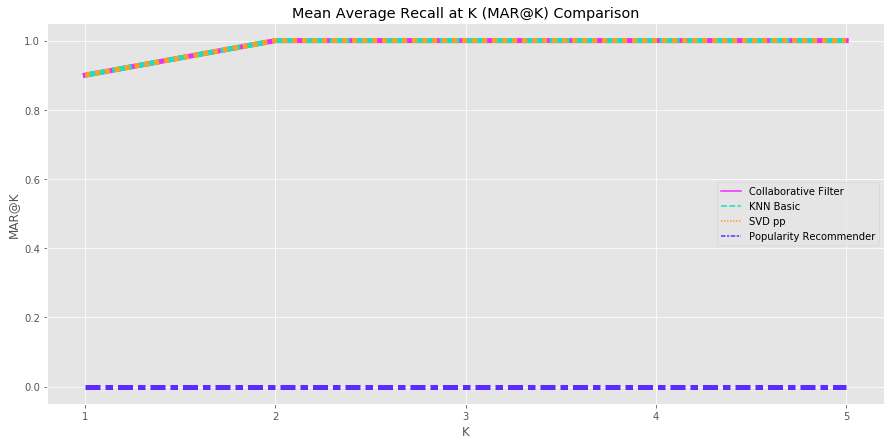

In [219]:
mark_scores = [cf_mark, knn_mark, svd_pp_mark, pop_mark]
idx = range(1,5+1)
names = ['Collaborative Filter', 'KNN Basic', 'SVD pp','Popularity Recommender']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=idx)

# Coverage Plot

Coverage - seberapa recommender dapat merekomendasikan item-item dari item yang ditrain

1390


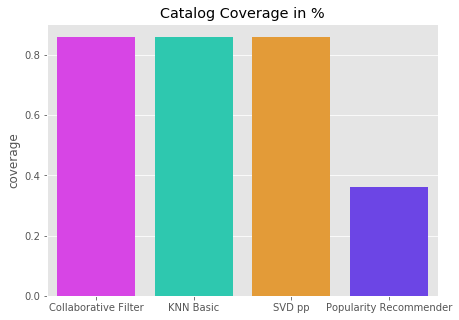

In [220]:
# mengumpulkan semua item_id_size ke dalam list

catalog = ratings.item_id_size.unique().tolist()
print(len(catalog))

# menghitung coverage
cf_coverage = recmetrics.coverage(cf_predictions, catalog)
knn_coverage = recmetrics.coverage(knn_predictions, catalog)
svd_pp_coverage = recmetrics.coverage(svd_pp_predictions, catalog)
pop_coverage = recmetrics.coverage(pop_predictions, catalog)

coverage_scores = [cf_coverage, knn_coverage, svd_pp_coverage, pop_coverage]
model_names =['Collaborative Filter', 'KNN Basic', 'SVD pp','Popularity Recommender']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)


coverage Collaborative Filter, KNN, dan SVD_pp lebih tinggi (1%) karena lebih memiliki variasi item. Sedangkan rekomendasi berdasarkan populeritas (0.3xx%) hanya 5 item itu-itu saja

# Personalization

### Nilai rerata dissimilarity dari konten yang direkomendasikan ke tiap2 user

In [221]:
testAll

,actual,cf_predictions,knn_predictions,svd_pp_predictions,pop_predictions
user_id,,,,,
989935,"[(2073553, 8)]","[(2073553, 8), (1000254, 16), (2701429, 4), (276763, 8), (2758095, 4)]","[(2073553, 8), (1000254, 16), (2701429, 4), (276763, 8), (2758095, 4)]","[(2073553, 8), (1000254, 16), (2701429, 4), (276763, 8), (2758095, 4)]","[(2552714, 8), (141300, 4), (889239, 4), (174086, 1), (512791, 8)]"
991099,"[(986296, 4)]","[(986296, 4), (2609834, 8), (276763, 8), (2758095, 4), (2752000, 16)]","[(986296, 4), (2609834, 8), (276763, 8), (2758095, 4), (2752000, 16)]","[(986296, 4), (2609834, 8), (276763, 8), (2758095, 4), (2752000, 16)]","[(2552714, 8), (141300, 4), (889239, 4), (174086, 1), (512791, 8)]"
994398,"[(2541835, 16), (2686855, 16)]","[(2541835, 16), (2686855, 16), (1000254, 16), (2701429, 4), (2758095, 4)]","[(2541835, 16), (2686855, 16), (1000254, 16), (2701429, 4), (2758095, 4)]","[(2541835, 16), (2686855, 16), (1000254, 16), (2701429, 4), (2758095, 4)]","[(2552714, 8), (141300, 4), (889239, 4), (174086, 1), (512791, 8)]"
996183,"[(2609834, 8)]","[(2609834, 8), (1000254, 16), (276763, 8), (2758095, 4), (2752000, 16)]","[(2609834, 8), (1000254, 16), (276763, 8), (2758095, 4), (2752000, 16)]","[(2609834, 8), (1000254, 16), (276763, 8), (2758095, 4), (2752000, 16)]","[(2552714, 8), (141300, 4), (889239, 4), (174086, 1), (512791, 8)]"
996512,"[(1522253, 14)]","[(1522253, 14), (1000254, 16), (2702384, 16), (276763, 8), (2758095, 4)]","[(1522253, 14), (1000254, 16), (2702384, 16), (276763, 8), (2758095, 4)]","[(1522253, 14), (1000254, 16), (2702384, 16), (276763, 8), (2758095, 4)]","[(2552714, 8), (141300, 4), (889239, 4), (174086, 1), (512791, 8)]"


In [222]:
cf_result = testAll.cf_predictions
knn_result = testAll.knn_predictions
svd_pp_result = testAll.svd_pp_predictions
pop_result = testAll.pop_predictions

In [223]:
personal_cf = recmetrics.personalization(predicted=cf_result)
personal_knn = recmetrics.personalization(predicted=knn_result)
personal_svd_pp = recmetrics.personalization(predicted=svd_pp_result)
personal_pop = recmetrics.personalization(predicted=pop_result)

print(personal_cf,"|", personal_knn,"|",personal_svd_pp,"|",personal_pop)

0.5 | 0.5 | 0.5 | 2.220446049250313e-16


# Intra-list Similarity

### Nilai rerata kecocokan item rekomendasi dari masing-masing user

In [224]:
items.head()

,blazer,blouse,bomber,caftan,cape,cardigan,coat,combo,culotte,culottes,down,dress,gown,henley,hoodie,jacket,jogger,jumpsuit,knit,maxi,midi,mini,pant,pants,poncho,print,pullover,romper,sheath,shift,shirt,shirtdress,skirt,sweater,sweatshirt,tank,top,trench,trouser,tunic,turtleneck,vest,rating,score
item_id_size,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(616682, 12)",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,9.555396
"(568429, 4)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,9.555396
"(1729232, 1)",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,9.555396
"(172027, 8)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,9.555396
"(197391, 12)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,7.555396


In [225]:
feature_df = items

In [226]:
recmetrics.intra_list_similarity(cf_result, feature_df)

0.9934953259521485

In [227]:
recmetrics.intra_list_similarity(knn_result, feature_df)

0.9934953259521485

In [228]:
recmetrics.intra_list_similarity(svd_pp_result, feature_df)

0.9934953259521485

In [229]:
recmetrics.intra_list_similarity(pop_result, feature_df)

0.994856652920739

# Final Dump

In [278]:
# Retrieve the whole all trainset.
trainset = data.build_full_trainset()

# Build an algorithm, and train it.

#train SVD recommender 
algo = SVD()
algo.fit(trainset)


algo2 = KNNBasic()
algo2.fit(trainset)


algo3 = SVDpp()
algo3.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [279]:
test = algo.test(testset)
test2 = algo2.test(testset)
test3 = algo3.test(testset)

In [282]:
testAll = pd.DataFrame(test)
testAll.drop("details", inplace=True, axis=1) # column mula2 -> uid, iid, r_ui, est
testAll.columns = ['user_id', 'item_id_size', 'actual', 'cf_predictions']
testAll.head()

test2 = pd.DataFrame(test2)
test2.head()
testAll['knn_basic_pred'] =test2['est']

test3 = pd.DataFrame(test3)
test3.head()
testAll['svd_pp_pred'] =test3['est']
testAll.head()

,user_id,item_id_size,actual,cf_predictions,knn_basic_pred,svd_pp_pred
0,725872,"(1014880, 20)",6.0,8.095181,6.0,7.948390
1,112850,"(545632, 8)",10.0,9.378672,10.0,9.256410
2,113975,"(379441, 8)",10.0,9.871744,10.0,9.849942
3,518720,"(1549943, 45)",8.0,8.758853,8.0,8.929436
4,269712,"(1522253, 8)",10.0,9.284066,10.0,9.328867


In [284]:
#create model (matrix of predicted values)

cf_model = testAll.pivot_table(index='user_id', columns='item_id_size', values='cf_predictions').fillna(0)
print(cf_model.shape)
cf_model.head()


knn_model = testAll.pivot_table(index='user_id', columns='item_id_size', values='knn_basic_pred').fillna(0)
print(knn_model.shape)
knn_model.head()


svd_pp_model = testAll.pivot_table(index='user_id', columns='item_id_size', values='svd_pp_pred').fillna(0)
print(svd_pp_model.shape)
svd_pp_model.head()

(240, 359)
(240, 359)
(240, 359)


item_id_size,"(1000254, 16)","(1009845, 28)","(1014880, 20)","(1017726, 35)","(1017773, 20)","(1034310, 20)","(1034372, 8)","(1051003, 4)","(1053467, 12)","(1063761, 8)","(1073611, 1)","(1076484, 16)","(1098399, 16)","(1099530, 4)","(1110676, 20)","(1113191, 4)","(1121132, 4)","(1133906, 4)","(1138140, 4)","(1142056, 20)","(1154504, 12)","(1154732, 24)","(1158451, 1)","(1158451, 4)","(1213752, 8)","(1223581, 4)","(1223725, 16)","(123373, 16)","(124553, 8)","(1250402, 4)","(1255726, 4)","(1257812, 20)","(1260731, 4)","(1260731, 14)","(127865, 13)","(128730, 16)","(1289744, 12)","(1299190, 1)","(1299555, 8)","(1310167, 8)","(1314014, 4)","(1314666, 8)","(1316404, 12)","(1316534, 1)","(1320203, 8)","(1329015, 12)","(1329021, 4)","(1333481, 4)","(1334351, 8)","(133584, 12)","(1344940, 12)","(1346753, 16)","(1346753, 28)","(1355618, 8)","(136110, 4)","(136860, 1)","(1375928, 14)","(1378631, 1)","(1383415, 8)","(1383632, 16)","(1384766, 1)","(1386350, 4)","(1392841, 12)","(141300, 4)","(1414750, 20)","(143094, 4)","(145906, 7)","(1459683, 16)","(1469072, 12)","(148690, 16)","(1499752, 20)","(1505709, 20)","(1514308, 20)","(1516843, 1)","(1522253, 8)","(1522253, 14)","(1523096, 16)","(1523882, 4)","(152836, 12)","(1542250, 39)","(1542251, 8)","(1549943, 45)","(1570915, 8)","(1576857, 4)","(1576942, 8)","(1578308, 1)","(1589928, 4)","(1593041, 24)","(1600987, 8)","(1615177, 12)","(1621646, 20)","(1629567, 16)","(1639988, 12)","(1648416, 4)","(1649107, 8)","(1651169, 4)","(1652667, 1)","(166006, 16)","(166633, 8)","(1671818, 16)","(1679360, 8)","(1685669, 14)","(1719559, 4)","(172914, 8)","(1734300, 8)","(1739627, 4)","(174086, 1)","(1745932, 24)","(174799, 16)","(174799, 20)","(1749759, 1)","(1752487, 8)","(1769671, 16)","(1776178, 8)","(178058, 4)","(1780941, 12)","(1783600, 20)","(1787191, 12)","(1788074, 20)","(1795593, 20)","(1799162, 4)","(1799162, 16)","(1813420, 8)","(1813420, 12)","(1814462, 8)","(1819243, 8)","(1821048, 16)","(1822664, 8)","(1842684, 8)","(1845435, 17)","(1853367, 8)","(1855564, 14)","(1858651, 8)","(1859039, 14)","(1859977, 4)","(1861964, 16)","(1861964, 24)","(1869763, 12)","(1875650, 4)","(1877861, 8)","(1894639, 20)","(1895348, 1)","(1895348, 16)","(1905844, 12)","(1909065, 13)","(1913039, 1)","(1924247, 4)","(1940255, 24)","(194182, 8)","(1944337, 4)","(1951168, 8)","(1954824, 4)","(197391, 12)","(1976130, 8)","(1984705, 1)","(1992563, 4)","(1994978, 8)","(1995373, 8)","(2002292, 4)","(2011987, 1)","(2014707, 14)","(2015822, 8)","(2033686, 5)","(2035790, 8)","(2046224, 24)","(2053531, 8)","(2057975, 4)","(2057975, 8)","(2059409, 8)","(2060880, 4)","(2063849, 8)","(2071488, 8)","(2073553, 8)","(2077141, 8)","(208647, 8)","(2089809, 8)","(2098918, 8)","(2117415, 8)","(2120468, 1)","(2121378, 12)","(2130194, 8)","(2135899, 14)","(2140050, 8)","(2148471, 4)","(2158754, 8)","(2164765, 4)","(2196467, 14)","(2209432, 4)","(2226744, 4)","(2231774, 20)","(2252462, 4)","(2252462, 14)","(2257456, 16)","(2259753, 8)","(226072, 12)","(2292972, 4)","(2300010, 8)","(2303128, 8)","(2319586, 8)","(2343090, 1)","(2363191, 1)","(2367913, 14)","(2376757, 20)","(2378271, 14)","(241759, 12)","(2440235, 4)","(2443419, 8)","(2444721, 12)","(2465306, 8)","(2472076, 12)","(247465, 1)","(2483440, 8)","(2484216, 14)","(2494898, 8)","(2531493, 3)","(2537366, 14)","(2541835, 16)","(2546173, 16)","(2552714, 8)","(2553295, 8)","(2557055, 12)","(2573155, 4)","(2575124, 12)","(2578061, 4)","(2599464, 4)","(2609834, 8)","(2616422, 8)","(2622144, 20)","(2635020, 14)","(2647046, 4)","(2654048, 1)","(2655365, 8)","(265806, 12)","(2670837, 12)","(2686855, 16)","(2696263, 8)","(2701429, 4)","(2702384, 16)","(2707029, 8)","(2707303, 8)","(2716360, 12)","(2729447, 4)","(2730831, 4)","(2752000, 16)","(2758095, 4)","(276763, 8)","(2769576, 2)","(2775831, 12)","(2780710, 8)","(2785640, 20)","(2787036, 8)","(2787036, 14)","(2791864, 12)","(279859, 1)","(2806136, 8)","(2827807, 16)","(2828426, 4)","(2856326, 4)","(2856326, 8)","(2861781, 12)","(28624

In [390]:
items_call = items.copy()
# xyz = (items.index.tolist())
items_call['idd'] = items_call.index


,blazer,blouse,bomber,caftan,cape,cardigan,coat,combo,culotte,culottes,down,dress,gown,henley,hoodie,jacket,jogger,jumpsuit,knit,maxi,midi,mini,pant,pants,poncho,print,pullover,romper,sheath,shift,shirt,shirtdress,skirt,sweater,sweatshirt,tank,top,trench,trouser,tunic,turtleneck,vest,rating,score,idd
item_id_size,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(616682, 12)",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,9.555396,"(616682, 12)"


In [392]:
popularity_recs_final = ratings.item_id_size.value_counts().index.tolist()
x = popularity_recs_final[:6]
x[0]
# type(x[0])
# items.loc[x[4]]
items_call[items_call['idd'] == x[0]]

# dumping
items_call.to_pickle('items_call') 

In [288]:
# surprise.dump.dump(file_name, predictions=None, algo=None, verbose=0)
from surprise import dump

dump.dump('cf_model', predictions = cf_model)
dump.dump('knn_model', predictions = knn_model)
dump.dump('svdpp_model', predictions = svd_pp_model)

In [330]:
# try to load
# surprise.dump.load(file_name)

model1, algo = dump.load('cf_model')
user_valids = model1.index
# 
model2, algo = dump.load('knn_model')
model3, algo = dump.load('svdpp_model')

In [394]:

n = 200
if n > (len(user_valids)-1):
    "belum ada rekomendasi"
else:
    uid = str(user_valids[n])
    print(get_users_predictions(uid, 5, model1))
    reko1 = get_users_predictions(uid, 5, model1)
    print(get_users_predictions(uid, 5, model2))
    reko2 = get_users_predictions(uid, 5, model2)
    print(get_users_predictions(uid, 5, model3))
    reko3 = get_users_predictions(uid, 5, model3)

[('1213752', 8), ('2769576', 2), ('276763', 8), ('2758095', 4), ('2752000', 16)]
[('1213752', 8), ('2769576', 2), ('276763', 8), ('2758095', 4), ('2752000', 16)]
[('1213752', 8), ('2769576', 2), ('276763', 8), ('2758095', 4), ('2752000', 16)]


In [402]:
itemscall = pd.read_pickle('items_call')

def getItemInIDD(reko):
    all = pd.DataFrame()
    for i in reko1 :
        tem = (itemscall[items_call['idd'] == i])
        all = pd.concat([all,tem])
    return all

getItemInIDD(reko1)

,blazer,blouse,bomber,caftan,cape,cardigan,coat,combo,culotte,culottes,down,dress,gown,henley,hoodie,jacket,jogger,jumpsuit,knit,maxi,midi,mini,pant,pants,poncho,print,pullover,romper,sheath,shift,shirt,shirtdress,skirt,sweater,sweatshirt,tank,top,trench,trouser,tunic,turtleneck,vest,rating,score,idd
item_id_size,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(1213752, 8)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,8.555396,"(1213752, 8)"
"(2769576, 2)",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,8.555396,"(2769576, 2)"
"(276763, 8)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,9.555396,"(276763, 8)"
"(2758095, 4)",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,8.555396,"(2758095, 4)"
"(2752000, 16)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,8.555396,"(2752000, 16)"


In [403]:
getItemInIDD(reko2)

,blazer,blouse,bomber,caftan,cape,cardigan,coat,combo,culotte,culottes,down,dress,gown,henley,hoodie,jacket,jogger,jumpsuit,knit,maxi,midi,mini,pant,pants,poncho,print,pullover,romper,sheath,shift,shirt,shirtdress,skirt,sweater,sweatshirt,tank,top,trench,trouser,tunic,turtleneck,vest,rating,score,idd
item_id_size,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(1213752, 8)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,8.555396,"(1213752, 8)"
"(2769576, 2)",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,8.555396,"(2769576, 2)"
"(276763, 8)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,9.555396,"(276763, 8)"
"(2758095, 4)",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,8.555396,"(2758095, 4)"
"(2752000, 16)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,8.555396,"(2752000, 16)"


In [404]:
getItemInIDD(reko3)

,blazer,blouse,bomber,caftan,cape,cardigan,coat,combo,culotte,culottes,down,dress,gown,henley,hoodie,jacket,jogger,jumpsuit,knit,maxi,midi,mini,pant,pants,poncho,print,pullover,romper,sheath,shift,shirt,shirtdress,skirt,sweater,sweatshirt,tank,top,trench,trouser,tunic,turtleneck,vest,rating,score,idd
item_id_size,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(1213752, 8)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,8.555396,"(1213752, 8)"
"(2769576, 2)",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,8.555396,"(2769576, 2)"
"(276763, 8)",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,9.555396,"(276763, 8)"
"(2758095, 4)",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,8.555396,"(2758095, 4)"
"(2752000, 16)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,8.555396,"(2752000, 16)"
